In [84]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

from model.vq_vae import VectorQuantize, ResBlock

In [85]:
device = 'xpu'
if device == 'xpu':
    import intel_extension_for_pytorch as ipex

In [86]:
dataset = MNIST(root='data', train=False, transform=ToTensor())

In [87]:
vqvae = torch.load('vq-best.safetensors', weights_only=False, map_location='xpu')
vqvae.eval()

VectorQuantize(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ResBlock(
      (block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ResBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
   

In [226]:
ar = torch.load('ar-epoch06.pth', weights_only=False)

In [227]:
def ar_genearte(label: torch.Tensor, vqvae, ar, temperature = 1):
    B = label.shape[0]
    sos = ar.sos_tokens(label)
    print('sos', sos.shape)
    x = sos.unsqueeze(1)
    for i in range(ar.max_len):
        logits = ar.forward(x)
        # print('logits', logits.shape)
        logit = logits[:, -1, :]
        # print('logit', logit.shape)
        logit = F.softmax(logit / temperature, dim=1)
        indx = torch.multinomial(logit, 1)
        # print('indx', indx.shape)
        quantized = vqvae.codebook(indx)
        # print('quantized', quantized.shape)
        x = torch.concat([x, quantized], dim=1)
    generated = vqvae.decode(x[:, 1:])
    return generated

sos torch.Size([1, 128])
torch.Size([1, 1, 28, 28])


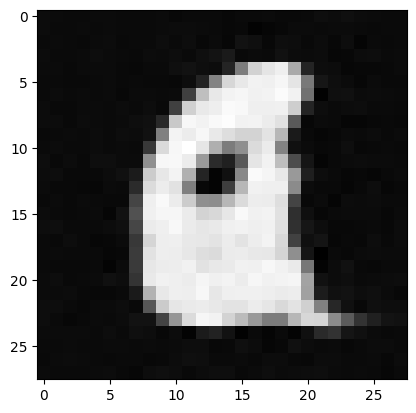

In [256]:
generated = ar_genearte(torch.tensor([5]), vqvae, ar, temperature=0.5)
plt.imshow(generated[0][0].detach().cpu().numpy(), cmap='gray')
print(generated.shape)